# Full Text Title Features

In this notebook we look at building features using the title and the full text of the article for solving both our binary classificaiton and multilabel classification problem. As usual we begin by importing essential data analysis libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seaborn will modify our matplotlib plots to a certain color and aesthetic to be more presentable.
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

Additionally, we will now import libaries related to natural language processing and cleaning. 

In [2]:
import nltk

#### Reading in Data

Our first task is to read in and inspect the data. Here we will be using imports of the full text previously generated by Rui. This is just an approximation of the actual sections but will make due for our purposes. 

In [3]:
# First ddefine a path to the file containing the dataset of the seperated full text articles
path = "../../Data/processed_text.csv"

# Read in and print out the first few rows of the data frame to inspect its contents.
text_df = pd.read_csv(path)
print(text_df.shape)
text_df.head();

(226, 9)


Now we will read in the first remaining featuers of the dataset. 

In [7]:
path = "../../Data/data_with_features.csv"

# Read in and print out the first few rows of the data frame to inspect its contents.
features_df = pd.read_csv(path)
# Drop an extraneous column which is an artificat of previous analysis
# features_df = features_df.drop(["Unnamed: 0"], axis = 1)

# Print out head of the first few features
print(features_df.shape)
features_df.head()

(3000, 13)


unique_id    core_id                                       citing_title  \
0       CC1  158977742  Ontology-Based Recommendation of Editorial Pro...   
1       CC2  158977742  Ontology-Based Recommendation of Editorial Pro...   
2       CC3  158977742  Ontology-Based Recommendation of Editorial Pro...   
3       CC4  158977742  Ontology-Based Recommendation of Editorial Pro...   
4       CC5  158977742  Ontology-Based Recommendation of Editorial Pro...   

              citing_author  \
0  Thiviyan Thanapalasingam   
1  Thiviyan Thanapalasingam   
2  Thiviyan Thanapalasingam   
3  Thiviyan Thanapalasingam   
4  Thiviyan Thanapalasingam   

                                         cited_title cited_author  \
0  Web search personalization with ontological us...         Sieg   
1             Exploring Scholarly Data with Rexplore      Osborne   
2  Klink-2: Integrating Multiple Web Sources to G...      Osborne   
3  Forecasting the Spreading of Technologies in R...      Osborne   
4  Supporting Springer Nature Editors by means of...      Osborne   

                                    citation_context  citation_class_label  \
0  They usually generate user models that describ...                     5   
1  The Computer Science Ontology (CSO)[3]is a lar...                     0   
2  In order to do so, we characterized all SN pub...                     0   
3  This API supports a number of applications, in...                     0   
4  It works according to three main steps:1) It r...                     5   

   citation_influence_label    set       section  sent_idx  percent_in_article  
0                         0  train    discussion        29            0.874570  
1                         0  train        method        22            0.219240  
2                         0  train  introduction        12            0.116613  
3                         1  train        method        32            0.260542  
4                         1  train        method         7            0.171219

## Abstract Similarity

The first feature we will analyze is simple word overlap of the word in the `cited_title` feature and the abstract of the citing paper. To compute this we first will define a helper function which will eliminate stop words for any given text. 

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 

def drop_stop_words(title, should_lemmatize = False):
    """Drop the core english stopwords in a title. Additionally stem and lemmatize if required them as well."""
    
    # Break apart hyphenated words
    if type(title) is float:
        return []
    
    hyphen_split = title.split('-')
    title = " ".join(hyphen_split)
    
    # First tokenize the input to break it into parts
    word_tokens = word_tokenize(title)
    
    # Get the set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Filter and reconstruct. Also lemmatize words if required
    if should_lemmatize:
        lemmatizer = WordNetLemmatizer()
        filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if not w in stop_words]
    else:
        filtered_sentence = [w.lower() for w in word_tokens if not w in stop_words]

    return filtered_sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yasabaig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Create a new column in the dataframe to store the overlap feature
features_df["keyword_overlap"] = np.zeros(features_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in features_df.index:
    # Grab the cited title as well as the full text id
    cited_title = features_df.iloc[row]["cited_title"]
    core_id = features_df.iloc[row]["core_id"]
    
    # Now grab the abstract of the associated paper. Note that technically this is stored internally as a
    # one element data frame, so after indexing for the correct abstract, we call the .squeeze() command
    # to drop the unncessary dimension
    abstract = text_df[text_df["core_id"] == core_id]["abstract"].squeeze()
    
    # Compute the keyword overlap
    abstract_words = drop_stop_words(abstract, False)
    cited_words = drop_stop_words(cited_title, False)
    
    # Count the overlap
    overlap = len(set(abstract_words) & set(cited_words)) 
    features_df.at[row,"keyword_overlap"] = overlap

#### Measuring The Performance of the Feature

Now let's analyze how strong a feature keyword overlap is for both classes. We will assess this by making an ROC curve for each class. Let's start with the binary classification first. 

In [14]:
# Convert both features to numpy arrays for ease of use
y_score = features_df["keyword_overlap"].to_numpy()
y_true = features_df["citation_influence_label"].to_numpy()

(3000,)
(14,)


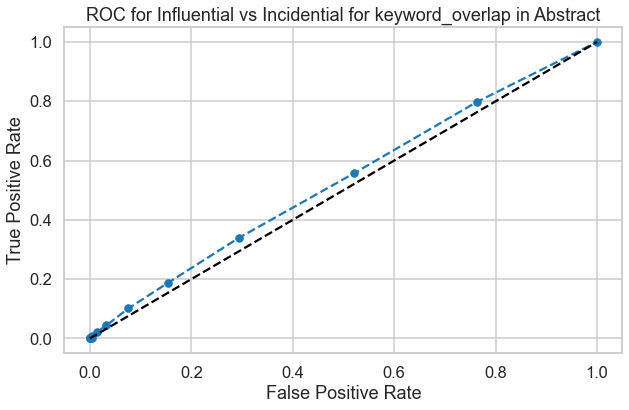

In [15]:
# Import sklearn ROC feature to make for rapid computing
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_true, y_score)
print(y_true.shape)
print(fpr.shape)
# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential for keyword_overlap in Abstract")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

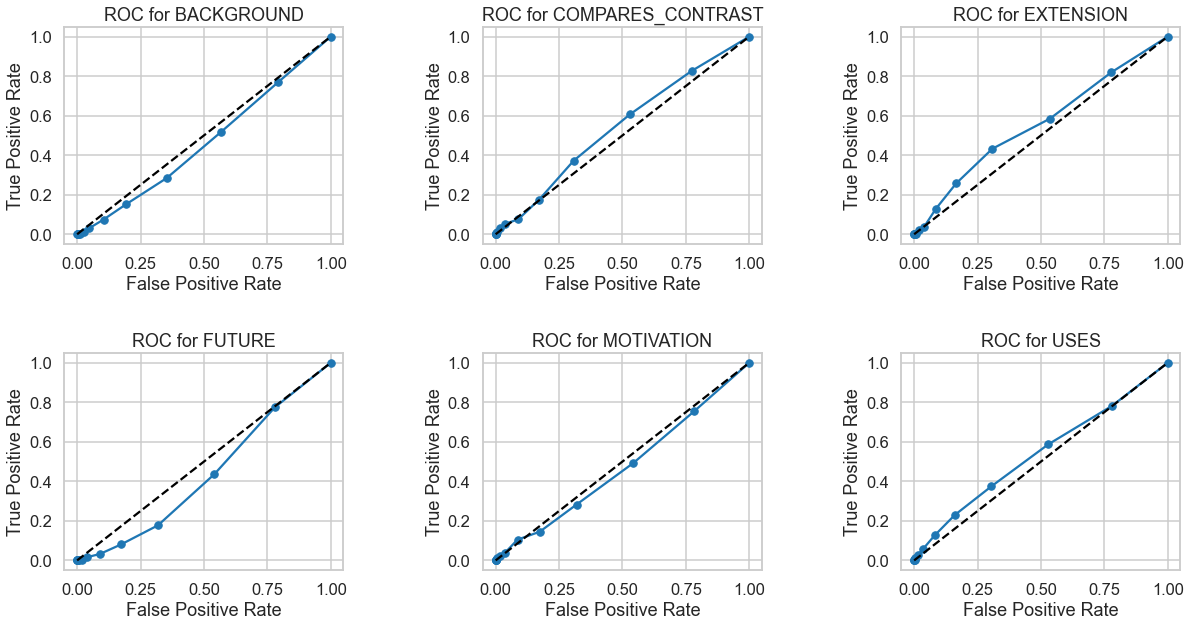

In [16]:
# Now for the multiclass
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    # Treat each as a one vs all classificaiton problem for each class
    y_true = (features_df["citation_class_label"] == i).astype(int).to_numpy()
    y_score = features_df["keyword_overlap"].to_numpy()
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, y_score/sum(y_score))

    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

## Generate Final Version of Feature

Lastly, let's generate a final version of this feature for the train/test set.

In [19]:
test_path = "../../Data/FINAL_DATA/SDP_test_features.csv"
train_path = "../../Data/FINAL_DATA/totaldata_features.csv"

In [27]:
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [37]:
# Create a new column in the dataframe to store the overlap feature
test_df["keyword_overlap"] = np.zeros(test_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in test_df.index:
    # Grab the cited title as well as the full text id
    cited_title = test_df.iloc[row]["cited_title"]
    core_id = test_df.iloc[row]["core_id"]
    
    # Now grab the abstract of the associated paper. Note that technically this is stored internally as a
    # one element data frame, so after indexing for the correct abstract, we call the .squeeze() command
    # to drop the unncessary dimension
    abstract = text_df[text_df["core_id"] == core_id]["abstract"].squeeze()
    
    # Compute the keyword overlap
    abstract_words = drop_stop_words(abstract, False)
    cited_words = drop_stop_words(cited_title, False)
    
    # Count the overlap
    overlap = len(set(abstract_words) & set(cited_words)) 
    test_df.at[row,"keyword_overlap"] = overlap

In [38]:
test_df

unique_id    core_id                                       citing_title  \
0        CCT1   81153632  Two steps back, one step forward: reconstructi...   
1        CCT2   81153632  Two steps back, one step forward: reconstructi...   
2        CCT3   81153632  Two steps back, one step forward: reconstructi...   
3        CCT4   81153632  Two steps back, one step forward: reconstructi...   
4        CCT5   81153632  Two steps back, one step forward: reconstructi...   
..        ...        ...                                                ...   
995    CCT996  187054964  Clinical Study Peritoneal Dialysis as a First ...   
996    CCT997  189217163  The trajectory of neurotoxic side effects' imp...   
997    CCT998  189217163  The trajectory of neurotoxic side effects' imp...   
998    CCT999  189217163  The trajectory of neurotoxic side effects' imp...   
999   CCT1000  189217163  The trajectory of neurotoxic side effects' imp...   

           citing_author                                        cited_title  \
0    Severin Hohensinner  The English village community examined in its ...   
1    Severin Hohensinner  Die italienischen Begr nder der Wiener Donauka...   
2    Severin Hohensinner  Wien im Bild historischer Karten Die Entwicklu...   
3    Severin Hohensinner  The hydraulic geometry of stream channels and ...   
4    Severin Hohensinner                      From memory to written record   
..                   ...                                                ...   
995       Roberto Barone  Survival of functionally anuric patients on au...   
996          Jenny Drott  Incidence prevalence and predictors of chemoth...   
997          Jenny Drott  Long term course of oxaliplatin induced polyne...   
998          Jenny Drott  Impact of oxaliplatin induced neuropathy a pat...   
999          Jenny Drott  Mental health outcomes during colorectal cance...   

    cited_author                                   citation_context  \
0        Seebohm  In historical research, regressive methods mov...   
1         Slezak  For example, a new cut-off channel at the Dona...   
2           Opll  It can be considered as the first map of the V...   
3        Leopold  According to the ''hydraulic geometry'' approa...   
4        Clanchy  Historians ask for the motivation and interest...   
..           ...                                                ...   
995        Brown  In contrast, in the NECOSAD study, the authors...   
996      Seretny  Oxaliplatin can cause acute and chronic neurot...   
997       Briani  The finding that neurotoxicity influences the ...   
998      Bennett  The finding that neurotoxicity influences the ...   
999       Mosher  The post-treatment survivorship can be a distr...   

     percent_in_article_no_ref  num_cit_in_paper  num_cit_in_introduction  \
0                     0.043736                 2                        1   
1                     0.401280                 1                        0   
2                     0.388817                 2                        0   
3                     0.769539                 2                        0   
4                     0.073995                 2                        1   
..                         ...               ...                      ...   
995                   0.788970                 2                        0   
996                   0.211639                 1                        1   
997                   0.853784                 1                        0   
998                   0.853784                 1                        0   
999                   0.847414                 1                        0   

     num_cit_in_method  num_cit_in_result  num_cit_in_discussion  first_loc  \
0                    0                  0                      0   0.038469   
1                    0                  0                      0   0.043736   
2                    1                  0                      0   0.328901   
3           

In [28]:
# Create a new column in the dataframe to store the overlap feature
train_df["keyword_overlap"] = np.zeros(train_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in test_df.index:
    # Grab the cited title as well as the full text id
    cited_title = train_df.iloc[row]["cited_title"]
    core_id = train_df.iloc[row]["core_id"]
    
    # Now grab the abstract of the associated paper. Note that technically this is stored internally as a
    # one element data frame, so after indexing for the correct abstract, we call the .squeeze() command
    # to drop the unncessary dimension
    abstract = text_df[text_df["core_id"] == core_id]["abstract"].squeeze()
    
    # Compute the keyword overlap
    abstract_words = drop_stop_words(abstract, False)
    cited_words = drop_stop_words(cited_title, False)
    
    # Count the overlap
    overlap = len(set(abstract_words) & set(cited_words)) 
    train_df.at[row,"keyword_overlap"] = overlap

In [39]:
train_df.head()
train_df.to_csv(train_path)
test_df.to_csv(test_path)

In [40]:
test_df.head()

unique_id   core_id                                       citing_title  \
0      CCT1  81153632  Two steps back, one step forward: reconstructi...   
1      CCT2  81153632  Two steps back, one step forward: reconstructi...   
2      CCT3  81153632  Two steps back, one step forward: reconstructi...   
3      CCT4  81153632  Two steps back, one step forward: reconstructi...   
4      CCT5  81153632  Two steps back, one step forward: reconstructi...   

         citing_author                                        cited_title  \
0  Severin Hohensinner  The English village community examined in its ...   
1  Severin Hohensinner  Die italienischen Begr nder der Wiener Donauka...   
2  Severin Hohensinner  Wien im Bild historischer Karten Die Entwicklu...   
3  Severin Hohensinner  The hydraulic geometry of stream channels and ...   
4  Severin Hohensinner                      From memory to written record   

  cited_author                                   citation_context  \
0      Seebohm  In historical research, regressive methods mov...   
1       Slezak  For example, a new cut-off channel at the Dona...   
2         Opll  It can be considered as the first map of the V...   
3      Leopold  According to the ''hydraulic geometry'' approa...   
4      Clanchy  Historians ask for the motivation and interest...   

   percent_in_article_no_ref  num_cit_in_paper  num_cit_in_introduction  \
0                   0.043736                 2                        1   
1                   0.401280                 1                        0   
2                   0.388817                 2                        0   
3                   0.769539                 2                        0   
4                   0.073995                 2                        1   

   num_cit_in_method  num_cit_in_result  num_cit_in_discussion  first_loc  \
0                  0                  0                      0   0.038469   
1                  0                  0                      0   0.043736   
2                  1                  0                      0   0.328901   
3                  0                  1                      0   0.647540   
4                  0                  0                      0   0.063835   

   keyword_overlap  
0              2.0  
1              0.0  
2              0.0  
3              2.0  
4              0.0